# Прогнозирование вероятности оттока клиентов

Сеть фитнес-центров поставила перед собой задачу снизить отток клиентов: научиться его прогнозировать и вовремя предпринимать шаги по удержанию клиентов. С решением задачи должны помочь аналитики.

**Задачи исследования**:

1. Спрогнозировать вероятность оттока для каждого клиента
2. Сегментировать клиентов и выделить черты, характерные для каждого сегмента
3. Изучить признаки, сильнее всего влияющие на отток
4. Предложить рекомендации по снижению оттока и работе с клиентами

## Знакомство с данными

In [1]:
import pandas as pd
import numpy as np

# библиотеки визуализации
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt

# библиотеки ML
from sklearn import datasets, tree, preprocessing, linear_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from IPython.display import HTML, display

# отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

In [2]:
%%javascript 
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Загрузим файл, посмотрим базовую информацию о таблице и что собой представляют данные.

In [3]:
df = pd.read_csv('gym_churn.csv')
display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


None

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


### Выводы

Предварительное знакомство с данными позволяет заключить:

- В датасете 4000 наблюдений (строк) и 14 полей.
- Из 14 столбцов один содержит целевую переменную (*Churn*), остальные 13 - это признаки. Их можно разделить на два типа:
    - Данные о пользователе (возраст, пол, факт проживания или работы рядом с центром, наличие телефона в базе и т.п.)
    - Данные об абонементе и посещаемости (длительность абонемента, срок в месяцах до окончания абонемента, средняя частота посещений в неделю и пр.)
- Категориальных признаков в датасете нет, только численные (формально к категориальным можно отнести длительность абонемента, но она также выражена числами - 1, 3, 6, 12).

Судя по всему, пропусков в данных нет. Далее мы изучим данные подробнее.

## Исследовательский анализ данных

Для удобства работы сократим и приведем к нижнему регистру названия столбцов.

In [4]:
df = (df.rename(columns={'Avg_additional_charges_total': 'extra_pay',
                        'Avg_class_frequency_total': 'avg_freq_total',
                        'Avg_class_frequency_current_month': 'avg_freq_month',
                        'Month_to_end_contract': 'month_to_end',
                         'Promo_friends': 'promo',
                        'Near_Location': 'near'})
     )

df.columns= df.columns.str.lower()

df.head()

,gender,near,partner,promo,phone,contract_period,group_visits,age,extra_pay,month_to_end,lifetime,avg_freq_total,avg_freq_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Выполним проверку на наличие дубликатов.

In [5]:
print("Дубликатов в таблице -", df.duplicated().sum())

Дубликатов в таблице - 0


Посмотрим на описательные статистики для количественных параметров в датасете.

In [6]:
df.describe()

,gender,near,partner,promo,phone,contract_period,group_visits,age,extra_pay,month_to_end,lifetime,avg_freq_total,avg_freq_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Наши наблюдения:

- Стандартное отклонение выше всего для поля с дополнительной выручкой, но это выглядит естественно - в финансовых данных часто бывает сильный разброс.
- Размерность признаков различается: для 6 признаков значения находятся в диапазоне между 0 и 1, для 2 признаков - между 1 и 12, для возраста - между 18 и 41, а для признака *extra_pay* - в диапазоне между 0 и 552.
- Возрастная группа довольно однородна - половина значений приходится на категорию 27-31 год, клиентов старше 41 года в выборке нет.
- Мальчиков и девочек среди клиентов приблизительно поровну.
- Большинство клиентов (84%) либо работают, либо живут рядом с фитнес-центром (признак *near*).
- Чуть менее половины клиентов (41%) хоть раз, да посещали групповые занятия (признак *group_visits*).
- Почти половина клиентов (48%) пришли по партнерской программе, а 30% воспользовались скидкой от друга.
- Средняя посещаемость - 1-2 раза в неделю. Также присутствуют выбросы за счет тех, кто посещает зал 6 раз в неделю.
- Средний lifetime клиента - чуть больше 3 месяцев.
- Выборка не сбалансирована. К классу ушедших клиентов в выборке относится 26%, а к классу активных - 74%.

Теперь посмотрим на средние значения признаков в двух группах: активных и ушедших клиентов.

In [7]:
df.groupby('churn').mean()

,gender,near,partner,promo,phone,contract_period,group_visits,age,extra_pay,month_to_end,lifetime,avg_freq_total,avg_freq_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


По этим данным можно предположить, что пол или возраст клиента не играют решающей роли в оттоке. А вот если клиент участвует в партнерских программах, пришел по рекомендации от друга или занимался в группе, то похоже, доля оттока в этих случаях ниже.

Скидки и социальные связи могут быть мощным фактором, влияющим на нашу целевую переменную. Далее нам предстоит выяснить это точнее.

Для полноты картины оценим распределение всех наших признаков при помощи графиков. Чтобы отрисовать все графики сразу, объявим функцию `overview_vis`. 

In [8]:
def overview_vis(dataset1, dataset2, row=5, col=1, title='Chart'):
    """Displays distribution plots for all features in listed datasets"""
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(20,20))
    fig.suptitle(title, fontsize='x-large')
    plt.subplots_adjust(hspace=0.3)
    
    for i, column in enumerate(dataset1.columns):
        ax = fig.add_subplot(row, col, i+1)
        ax.set_title(column)
        sns.distplot(dataset1[column], label='No churn')
        sns.distplot(dataset2[column], label='Churn')
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc='best', bbox_to_anchor=(0.05, 0.75, 0.1, 0.1), fontsize='x-large')
        

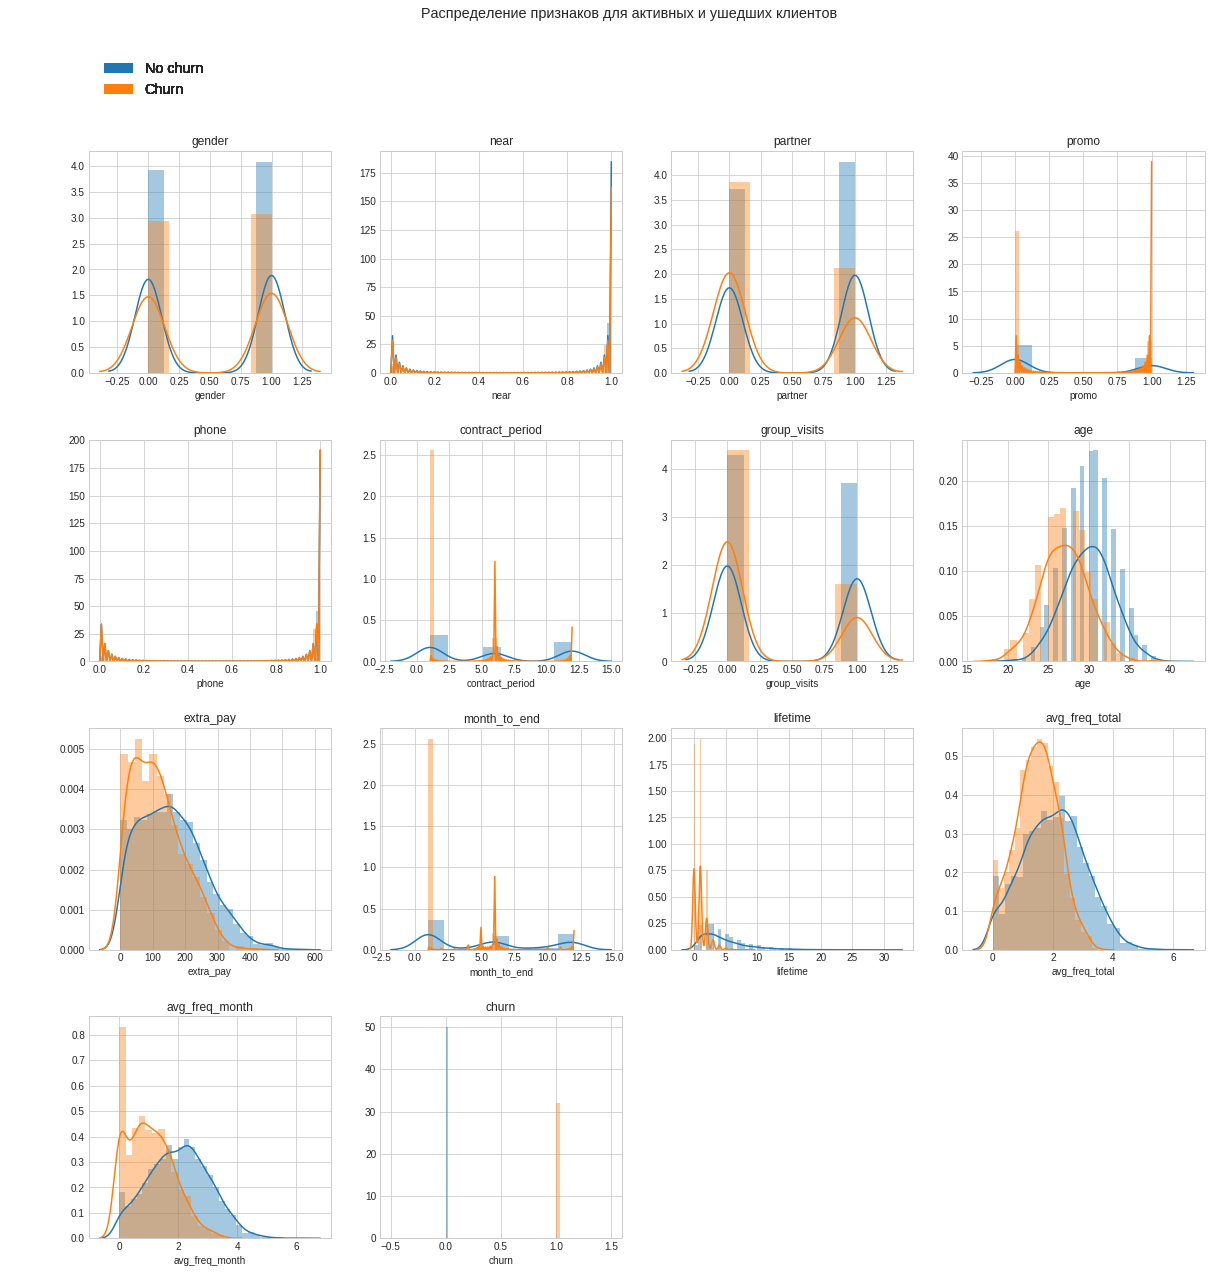

In [9]:
# выделим два датасета по признаку churn
no_churn = df.query('churn == 0')
churn = df.query('churn == 1')

# построим графики со сравнением всех признаков для активных и ушедших клиентов
(overview_vis(
        dataset1=no_churn, 
        dataset2=churn, 
        row=4, 
        col=4, 
        title='Распределение признаков для активных и ушедших клиентов')
)

Изучим их подробнее:

1) Гистограмма пола (*gender*) подтверждает, что женщин и мужчин в нашей выборке примерно поровну. Также нет данных в пользу того, что пол как-то коррелирует с фактом оттока.

2) Гистограмма близости к залу (*near*) сообщает, что в выборке преобладают клиенты, живущие или работающие рядом. На факт оттока это так же вряд ли оказывает влияние.

3) Гистограмма участия в партнерской программе (*partner*) показывает, что среди тех, кто участвовал в программе, отток почти вдвое меньше. Аналогичная картина для групповых занятий (гистограмма *group_visits*).

4) Гистограмма участия в промо "Приведи друга" (*promo*) на первый взгляд свидетельствует о том, что churn высок в обеих группах - и тех, кто участвовал в промо, и у всех остальных. Но дело в том, что в самой промо-акции участвовало не более трети клиентов, поэтому вряд ли это показательно.

5) По данным о возрасте (*age*) можно предположить, что молодежь бросает чаще - распределение ушедших клиентов смещено чуть влево. Выдвинем рабочую гипотезу, что средний возраст в этих группах различен (а значит, меньший возраст - это фактор риска с точки зрения оттока).

6) На гистограммах продолжительности абонемента (*contract_period*) и времени до его окончания (*month_to_end*) заметны пики в области 1. Получается, скорее бросают те, кто купил абонемент на небольшой срок: их не удерживает факт финансовых вложений, как в случае с покупкой годового абонемента. 

7) Гистограммы дополнительных трат (*extra_pay*), общей посещаемости (*avg_freq_total*) и посещаемости в последний месяц (*avg_freq_month*) во многом перекрываются для двух групп клиентов, хотя в группе ушедших клиентов пики выше. Особенно заметен выброс в области 0 на графике посещаемости в последний месяц. Это и логично - еще до фиксации факта оттока клиент постепенно перестает ходить.

В целом, аномальных выбросов в данных не наблюдается.

Теперь посмотрим на корреляцию между признаками. Таблица слишком велика и не наглядна, поэтому сразу выведем ее в виде тепловой карты.

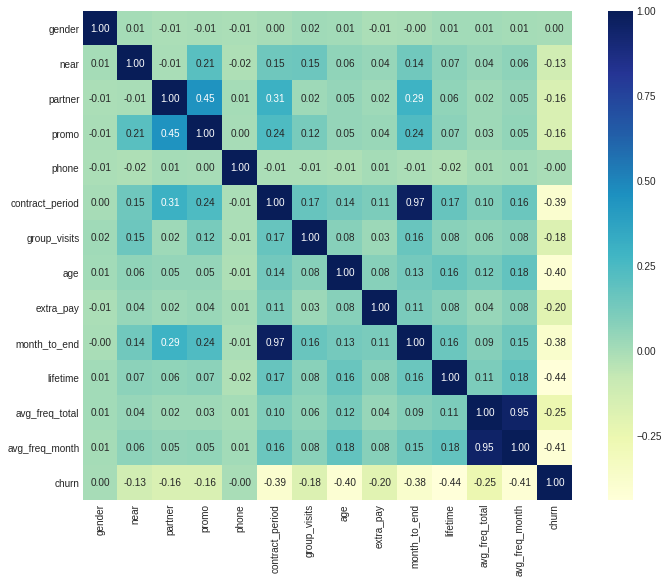

In [10]:
cm = df.corr()

# построим тепловую карту
plt.figure(figsize=(13, 9))
sns.heatmap(cm, annot=True, fmt='.2f',square=True, cmap="YlGnBu")
plt.show()

Видим высокую степень корреляции (> 0.8) в 2 парах признаков:

- Между длительностью абонемента и сроком до его окончания. Это логично, срок до окончания абонемента будет всегда меньше или равен длительности абонемента. 
- Между средней посещаемостью за все время и посещаемостью в последний месяц. Иными словами, если клиент начал ходить регулярно с самого начала, то с большой степенью вероятности он будет придерживаться избранного графика, избегая длительных отлучек или перерывов в посещении зала.

Признаков, явно коррелирующих с целевой переменной, в датасете нет.

При построении моделей нужно будет не забыть про коррелирующие столбцы, чтобы исключить мультиколлинеарность.

### Выводы

Наши наблюдения в результате исследовательского анализа данных:

- Выборка не сбалансирована по классам: в отток уходит около 25%, остается 75%.
- Признаки сильно различаются по размерности (некоторые в диапазоне от 0 до 1, другие от 1 до 12 и т.д.), поэтому нужно будет выполнить стандартизацию.
- По возрасту, полу, близости к фитнес-центру аудитория довольно однородна (нет перекосов/выбросов).
- Средний lifetime клиента - чуть больше 3 месяцев, а средняя посещаемость - 1-2 раза в неделю. Отдельные клиенты посещают зал до 6 раз в неделю.
- Если смотреть на средние значения признаков в зависимости от принадлежности к классу, то похоже, что в среднем пол или возраст не оказывают влияния на отток. Правда, ситуация может отличаться, если смотреть на отдельные сегменты клиентов. 
- В то же время участие в промо-акции или партнерских программах, похоже, могут снижать вероятность оттока.
- В датасете есть 2 пары признаков с сильной корреляцией (> 0.8): это общая посещаемость и посещаемость в последний месяц, а также длительность абонемента и время до окончания абонемента. Признаков, которые бы сильно коррелировали с целевой переменной, в датасете нет.

## Модель прогнозирования оттока клиентов

Для прогнозирования факта оттока будем решать задачу бинарной классификации ("есть отток - нет оттока"). Ее можно решить при помощи разных алгоритмов. Мы попробуем два: логистическую регрессию и случайный лес.

Сначала подготовим данные:
- выделим признаки и целевую переменную
- разобьем выборку на обучающую и валидационную
- выполним регуляризацию данных

In [11]:
# выделим признаки и целевую переменную в отдельные датафреймы
X = df.drop(['churn'], axis=1)
y = df['churn']

Также вспомним, что в нашем датасете есть сильно скоррелированные признаки. Чтобы исключить мультиколлинеарность, удалим вручную по одному признаку из каждой пары. Например, срок до окончания абонемента и посещаемость в последний месяц.

In [12]:
X = X.drop(['month_to_end', 'avg_freq_month'], axis=1)
X.head()

,gender,near,partner,promo,phone,contract_period,group_visits,age,extra_pay,lifetime,avg_freq_total
0,1,1,1,1,0,6,1,29,14.227470,3,0.020398
1,0,1,0,0,1,12,1,31,113.202938,7,1.922936
2,0,1,1,0,1,1,0,28,129.448479,2,1.859098
3,0,1,1,1,1,12,1,33,62.669863,2,3.205633
4,1,1,1,1,1,1,0,26,198.362265,3,1.113884


Осталось 11 признаков. 

Разделим выборку на обучающую и валидационную. Имеющиеся в датасете наблюдения независимы и не влияют на последующие, поэтому можно применить случайное разбиение.

Также нам понадобится выполнить стандартизацию, потому что иначе линейная регрессия выдаст некорректный результат - ведь у наших признаков сильно различается размерность.

In [13]:
# разделим выборку на обучающую и валидационную в отношении 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# применим стандартизацию к обучающей выборке и обучим ее
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)

# стандартизируем валидационную выборку
X_test_st = scaler.transform(X_test)

Теперь перейдем к обучению моделей. У нас их две, поэтому удобнее использовать функцию на тот случай, если захотим проверить другие модели.

In [14]:
#сохраним модели в список и сразу зададим для них параметры
models = [LogisticRegression(random_state=0, solver='liblinear'), 
          RandomForestClassifier(random_state=0, n_estimators = 100)
         ]

def prediction_metrics(m, X_train, y_train, X_test, y_test):
    """
    Строит и обучает модель по заданному алгоритму.
    Рассчитывает и выводит метрики для оценки спрогнозированных меток и вероятностей. 
    """
    model = m
    model.fit(X_train, y_train)
    
    # рассчитаем прогноз для целевой переменной
    y_pred = model.predict(X_test)

    # рассчитаем вероятность принадлежности объекта к первому или второму классу
    y_probas = model.predict_proba(X_test)
    
    # рассчитаем метрики для оценки качества прогноза
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    print('Accuracy: {:.2f}'.format(accuracy),
         'Precision: {:.2f}'.format(precision),
         'Recall: {:.2f}'.format(recall),
         'ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, y_probas[:,1])))

Перед оценкой метрик посмотрим на веса признаков, вычисленные для нашей линейной модели.

In [15]:
for m in models:
    try:
        weights = pd.DataFrame(data={'feature': X_train.columns, 'weight': m.coef_.flatten()})
        weights['weight_abs'] = weights['weight'].apply(lambda x: abs(x))
        display(weights.sort_values(by='weight_abs', ascending=False))
    except AttributeError:
        continue

Наибольший вес по модулю - у срока жизни клиента (*lifetime*), а также у длительности абонемента (*contract_period*). Это и понятно - клиенты, которые регулярно ходят в зал на протяжении нескольких месяцев, и бросают реже. Условия их устраивают, привычка к спорту вырабатывается, все хорошо. Те, кто покупают длительный абонемент, также больше мотивированы продолжать занятия - деньги уплачены, надо ходить.

А вот пол и участие в партнерских программах (хотя они и дают скидку) почти никакой роли не играют.

Посмотрим теперь на метрики.

In [16]:
for m in models:
    print(m.__class__.__name__)
    prediction_metrics(m, X_train_st, y_train, X_test_st, y_test)
    print()

LogisticRegression
Accuracy: 0.91 Precision: 0.83 Recall: 0.83 ROC_AUC: 0.96

RandomForestClassifier
Accuracy: 0.89 Precision: 0.81 Recall: 0.79 ROC_AUC: 0.95



По каждой из метрик модель логистической регрессии показывает чуть лучший результат, чем случайный лес.

Отдельно обратим внимание на значение accuracy - оно высокое, 90% в первом и 88% во втором случае. Как мы помним, классы у нас не сбалансированы (churn - примерно четверть от всех наблюдений, а не половина), поэтому эта метрика не очень показательна в данном случае.

Метрики точности и полноты явно похуже, но на приемлемом уровне. А вот ROC-AUC, которая особенно подходит для нашего случая с несбалансированными классами, близка к 1, так что обе модели прогнозируют неплохо. 

### Выводы

Для решения задачи мы решили построить две модели: на основе логистической регрессии и случайного леса. 

- Перед построением модели мы выполнили стандартизацию признаков и удалили сильно скоррелированные признаки (всего 2).
- Для линейной модели наибольший вес по модулю - у продолжительности жизни клиента (*lifetime*). Получается, чем меньше времени с нами клиент, тем выше риск оттока. 
- Такие параметры, как пол или участие в партнерской программе, получили низкий коэффициент - их влияние на отток невелико.
- Далее мы выбрали метрики для оценки качества моделей. По каждой из метрик модель логистической регрессии показала чуть лучший результат. 
- Метрика Accuracy в случае с несбалансированными классами не очень показательна, но метрика ROC-AUC близка к единице - значит, в целом модель адекватна. Что касается точности и полноты, то над этими метриками можно еще работать.

## Кластеризация клиентов

Как и у любого бизнеса, у фитнес-центров неоднородная аудитория: есть заядлые спортсмены, железно посещающие зал с железом 6 раз в неделю, а есть те, кто пытается начать новую жизнь с понедельника и вскоре бросает эти попытки. Люди разные, и поведение у них разное - бизнес должен понимать свою аудиторию, чтобы правильно с ней работать.

Попробуем типизировать аудиторию - то есть выделить кластеры при помощи методов машинного обучения.

Для начала посмотрим на дендрограмму, чтобы визуально оценить возможное количество кластеров.

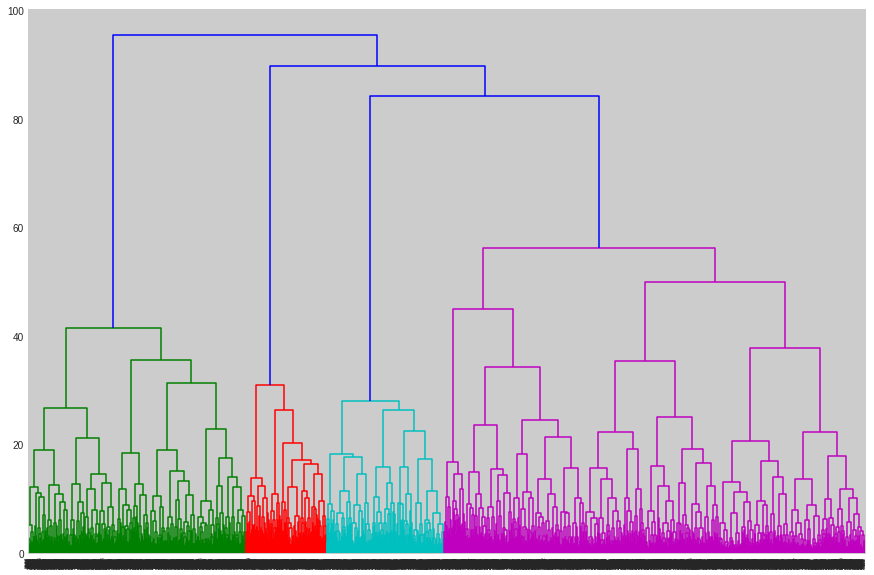

In [17]:
# стандартизируем матрицу признаков
scaler = StandardScaler()
X_st = scaler.fit_transform(X)

# сохраним таблицу связей между объектами
linked = linkage(X_st, method = 'ward') 

# построим дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show()

На графике выделяются 4 кластера, обозначенные разным цветом. Правда, фиолетовый кластер справа как минимум вдвое (а то и втрое) больше остальных. Решено - выделим 5 кластеров. Это позволит распределить клиентов более равномерно. 

In [18]:
# спрогнозируем кластеры клиентов
km = KMeans(n_clusters = 5, random_state=0)
labels = km.fit_predict(X_st)

Кластеры есть, теперь посмотрим на средние значения признаков по кластерам.

In [19]:
# сохраним метки в отдельный столбец в исходном датасете
df['cluster'] = labels

mean_feat = df.groupby('cluster').mean()
mean_feat

,gender,near,partner,promo,phone,contract_period,group_visits,age,extra_pay,month_to_end,lifetime,avg_freq_total,avg_freq_month,churn
cluster,,,,,,,,,,,,,,
0,0.499109,0.000000,0.488414,0.076649,1.0,3.032086,0.235294,28.721925,137.540009,2.853832,3.060606,1.770413,1.606619,0.399287
1,0.488571,0.995238,0.955238,0.892381,1.0,7.660952,0.458095,29.543810,155.861428,6.988571,4.380952,1.978963,1.933736,0.120952
2,0.505300,1.000000,0.238516,0.059187,1.0,2.819788,0.000000,28.770318,143.383993,2.650177,3.343640,1.800647,1.645965,0.381625
3,0.544202,1.000000,0.250287,0.079219,1.0,4.528129,1.000000,29.536165,148.088897,4.165327,3.761194,1.941342,1.845911,0.200918
4,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,4.466321,3.940415,1.854211,1.723967,0.266839


Уже по средним значениям можно примерно обрисовать характер сегмента и предположить их мотивацию.

**Кластер 0. Просто мимо проходил.** В половине случаев пришли по партнерской программе, но при этом спортзал не рядом с домом/работой. На групповые занятия ходят мало. Покупают абонемент на месяц и пару раз продлевают. Уходят в отток в 40% случаев - или нет мотивации заниматься, или же просто неудобно.

**Кластер 1. Фитнес-фанатики.** Это самая активная и сознательная часть аудитории - покупают абонементы на полгода-год, посещают зал 2 раза в неделю, а то и чаще. Средний lifetime - около 4 месяцев, отток низкий (12%). Часто приходят по партнерской программе или рекомендации друга. Чуть больше тратят денег на другие услуги по сравнению с остальными. Можно сказать, что это люди, которые привыкли о себе заботиться и выделять на это время и деньги, и проблем с удержанием этой части аудитории скорее всего нет.

**Кластер 2. Соседи.** Явно выбрали спортзал по принципу близости к дому или работе, но как правило не участвовали в промо или партнерских программах, скидкой не мотивированы. На групповые занятия не ходят вообще, покупают короткие абонементы и "отваливаются" в 38% случаев. Вероятно, нет привычки и тяги к спорту, а социальные связи не срабатывают, так как ходят одни. Это второй сегмент с высокой долей оттока.

**Кластер 3. Мы с Тамарой ходим парой.** От кластера 2 отличаются главным образом тем, что это абсолютные поклонники групповых занятий. Ходят стабильно дважды в неделю, покупают абонементы разной длины. Вероятно, спортзал их привлекает возможностью пообщаться и приятно провести время. Отток в среднем довольно низкий (20%).

**Кластер 4. Сфинксы.** Самый загадочный сегмент: никогда не оставляют контактного телефона, при этом часто приходят по партнерской программе и демонстрируют неплохой lifetime. В отток уходит около четверти. Возможно, это та категория, которая приходит "подкачаться к лету", но не мотивирована на постоянные занятия в течение года. Не исключено также, что это часть более крупного кластера (который виден на дендрограмме справа), поэтому здесь нет ярко выраженных характеристик.

Теперь посмотрим, как распределились признаки по каждому кластеру.

Для отрисовки графиков также воспользуемся функцией, но сделаем так, чтобы графики были разными в зависимости от типа переменных.

In [20]:
def cluster_overview(dataset):
    for i, column in enumerate(dataset.columns):
        if dataset.dtypes[column] == np.int:
            c = sns.catplot(x=column, data=df, col='cluster', kind='count')
            c.fig.subplots_adjust(top=0.8)
            c.fig.suptitle(column, fontsize=20)
            plt.show()
        elif dataset.dtypes[column] == np.float:
            sns.boxplot(x='cluster', y=column, data=dataset)
            plt.show()
        else:
            continue

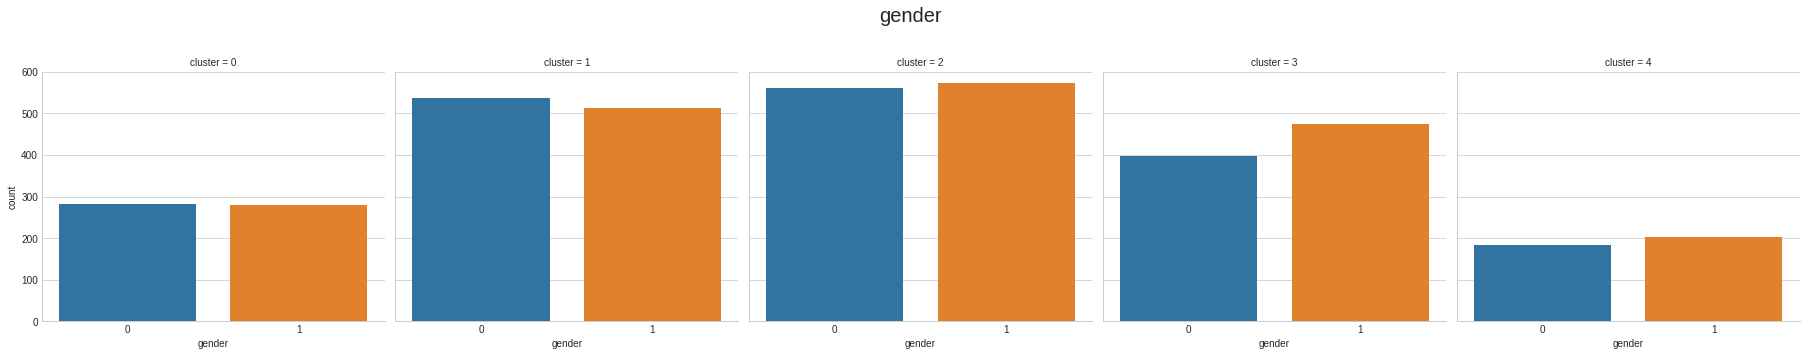

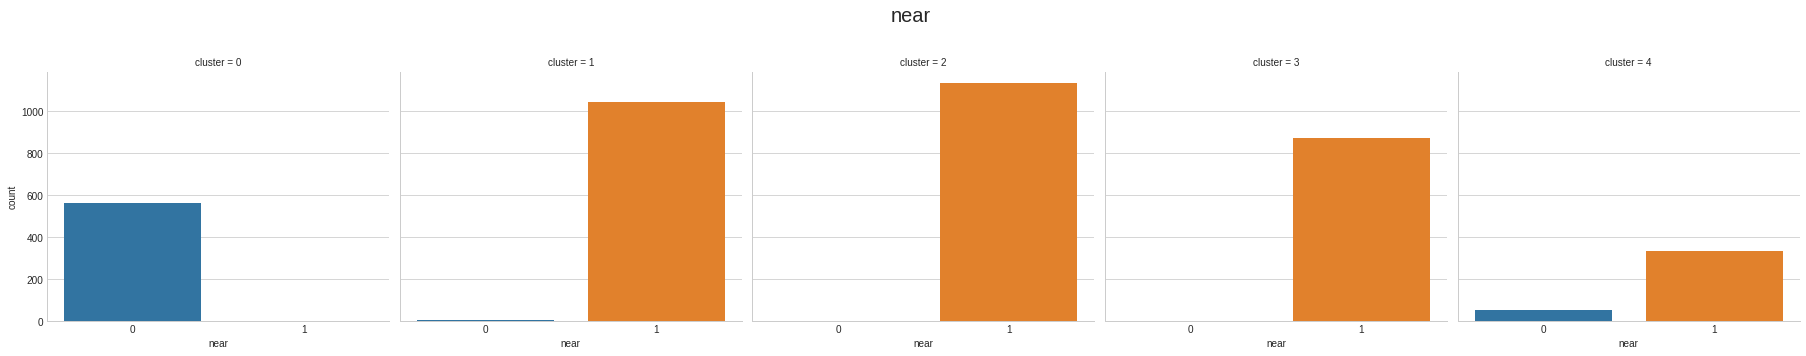

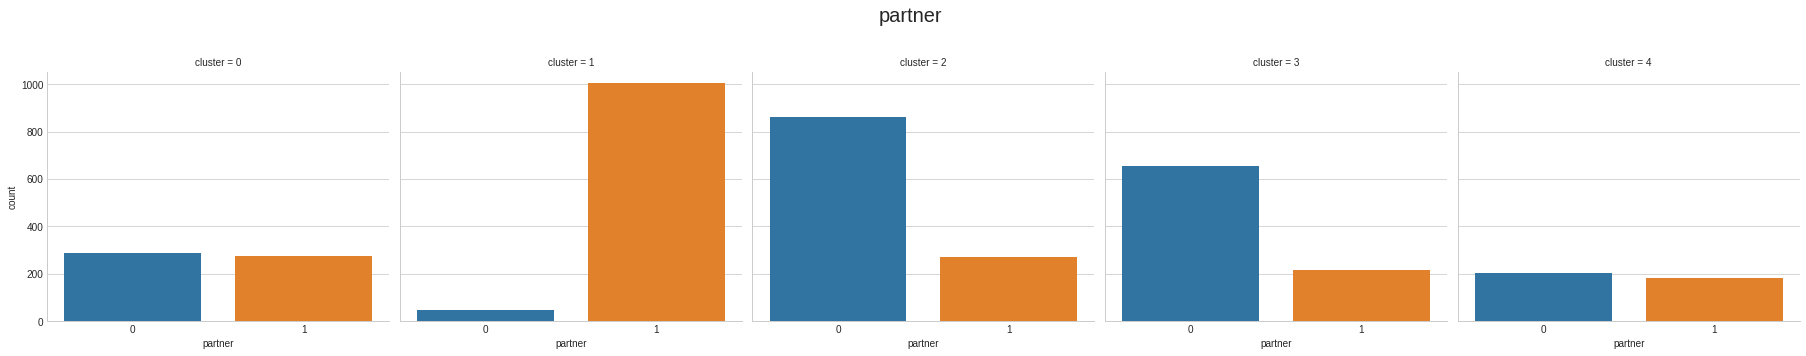

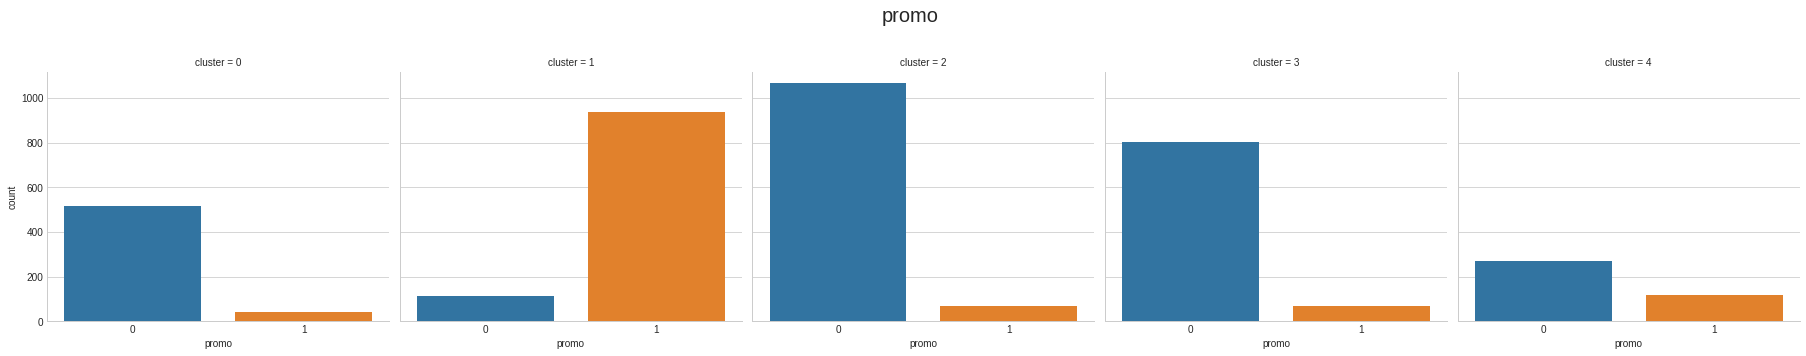

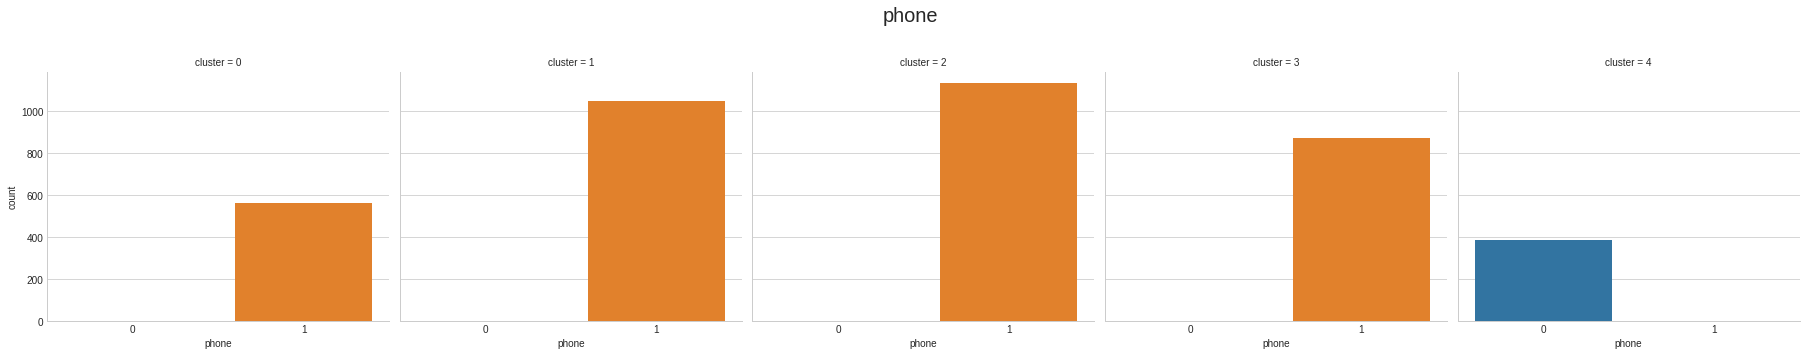

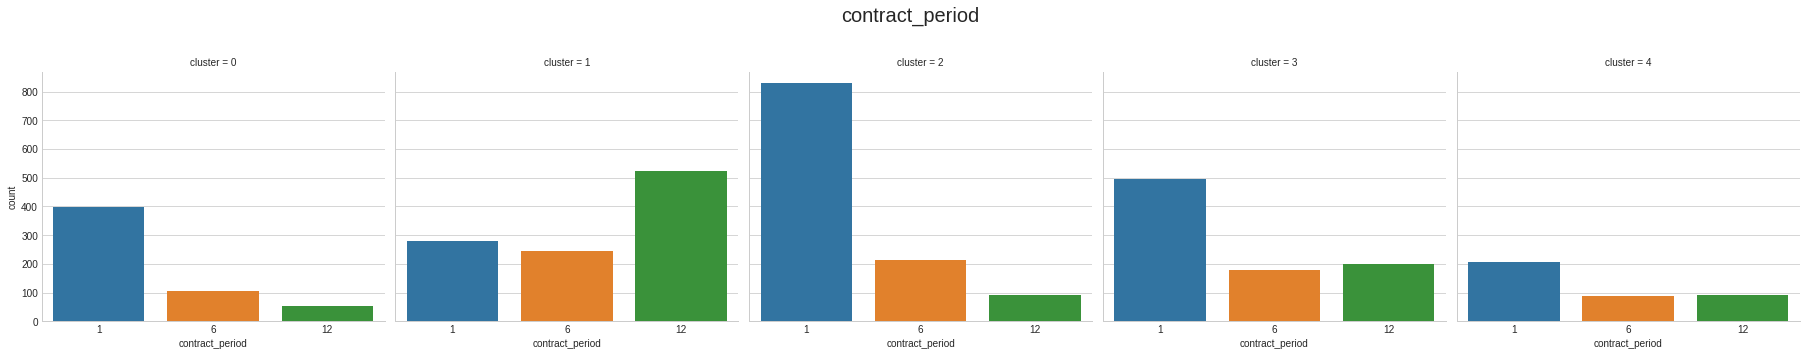

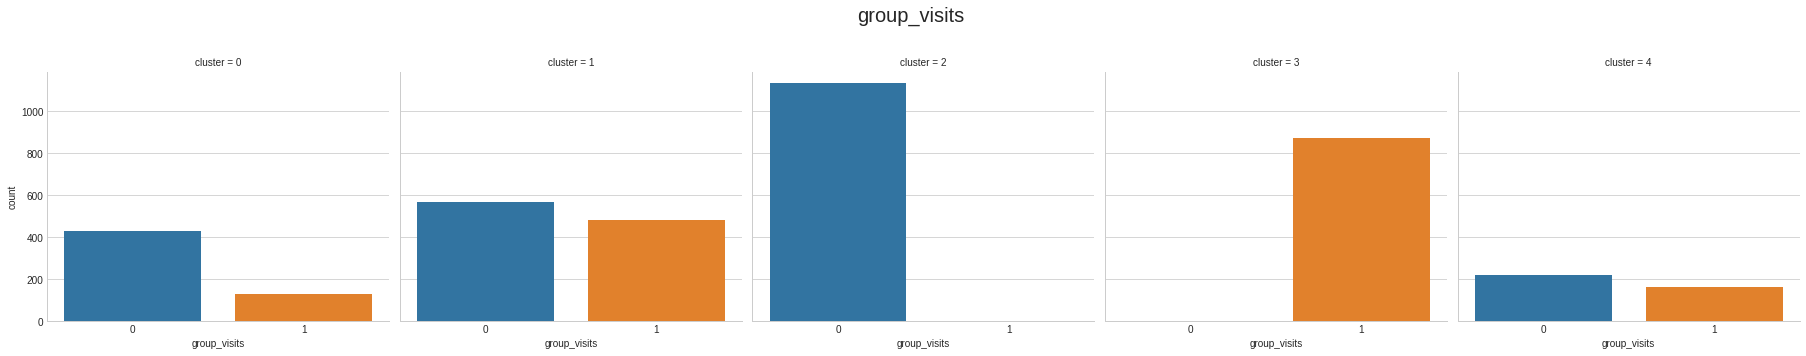

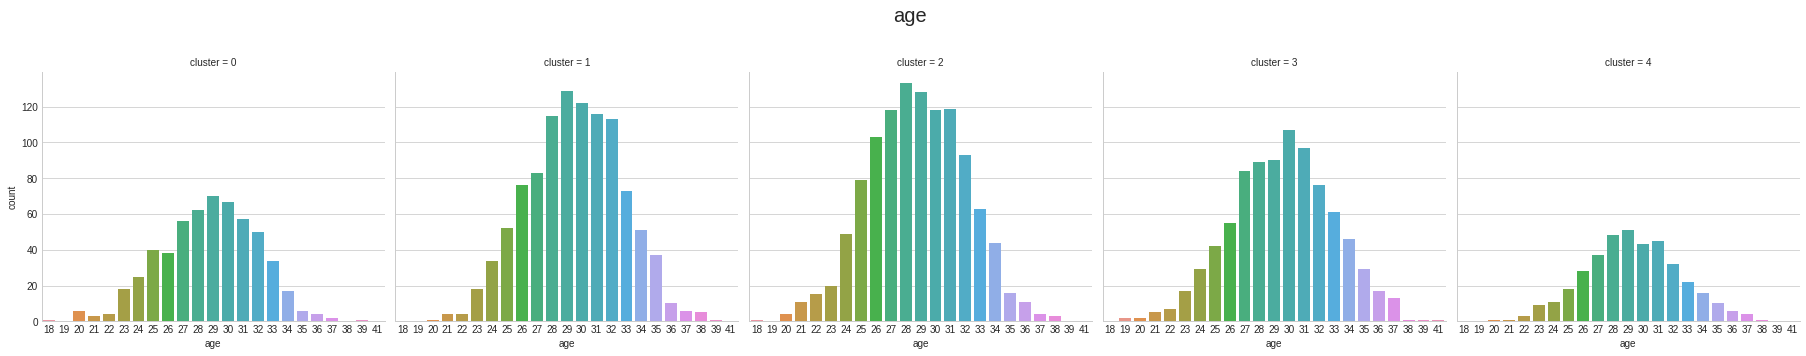

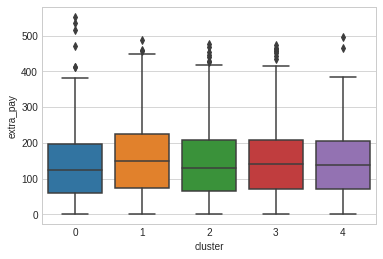

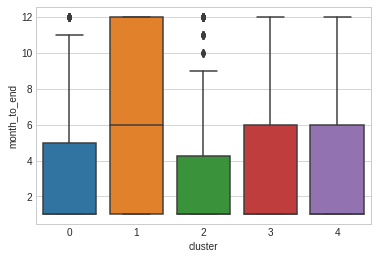

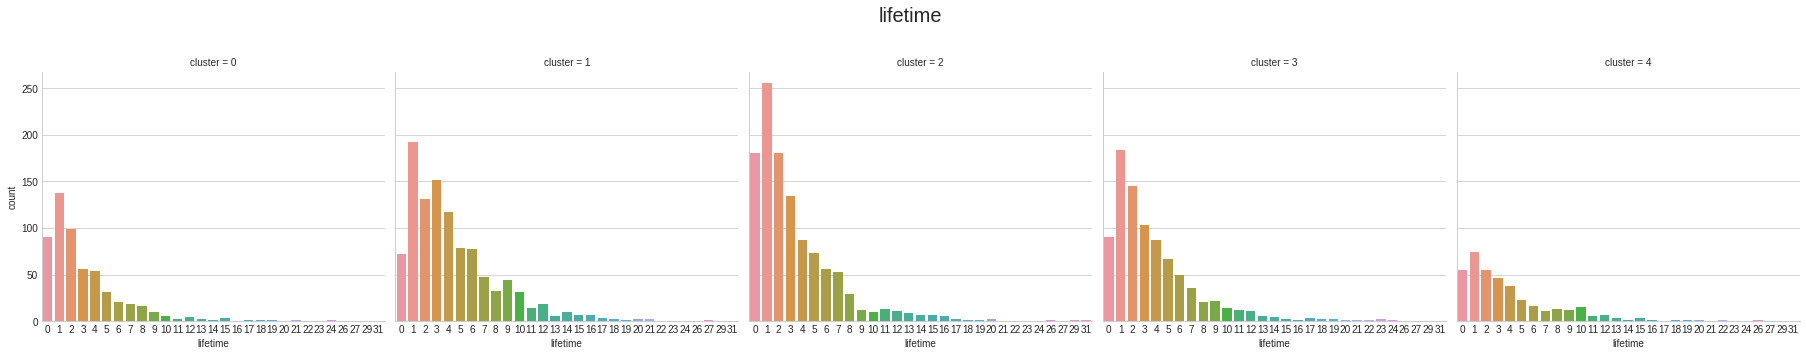

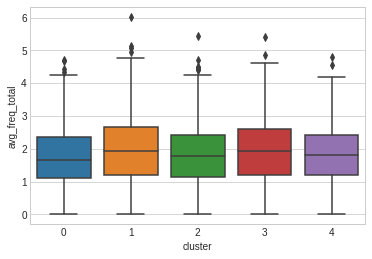

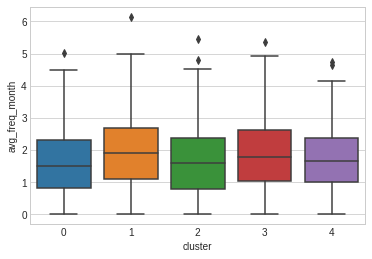

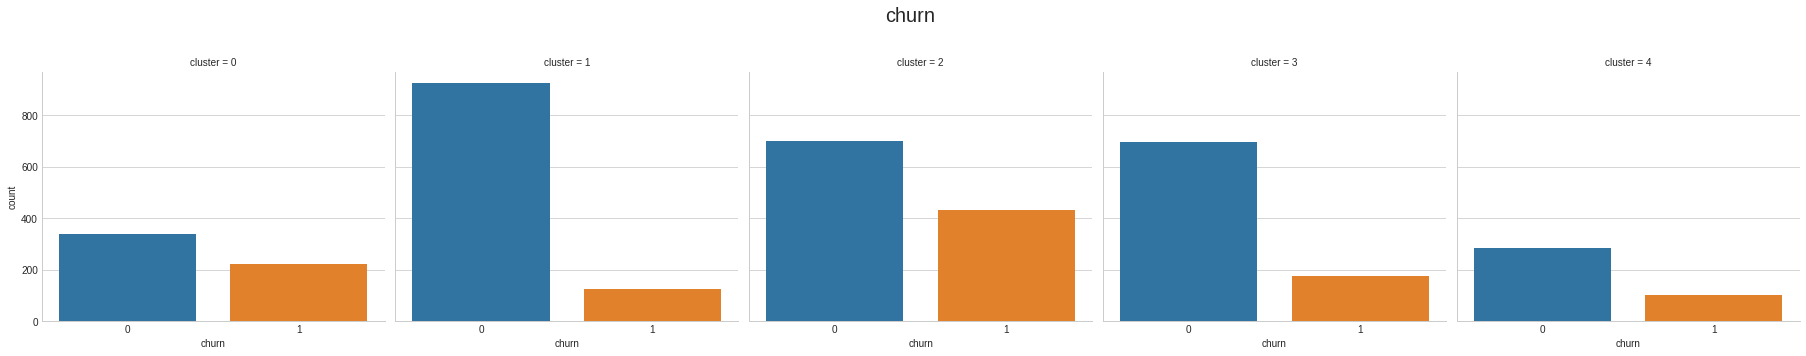

In [21]:
cluster_overview(df)

ПО графикам можно сделать следующие выводы:

- Распределение клиентов по полу равномерно во всех кластерах.
- По возрасту распределения очень похожи и напоминают нормальные, выбросов или пиков не наблюдается.
- Что касается трат, в среднем все тратят одинаково вне зависимости от сегмента. В кластере 0 заметно больше выбросов. Это может объясняться характером клиентов, которые склонны к импульсивным поступкам: в том числе, и тратам на абонемент.
- Распределение продолжительности жизни скошено вправо с пиком на 1 месяце. Получается, первый месяц - самый *рискованный с точки зрения оттока*.
- Средняя посещаемость у всех кластеров примерно на одном уровне - дважды в неделю. Есть выбросы, достигающие 5-6 раз в неделю, но они есть во всех кластерах, так что вряд ли это значимый фактор.
- Самым показательные из признаков - длина абонемента и факт посещения групповых занятий. Самые лояльные клиенты готовы к занятиям на длинной дистанции, а посещение групп укрепляет социальные связи. Инсайтом это назвать нельзя, но наблюдение согласуется со здравым смыслом.

В заключение посмотрим отдельно на долю оттока по каждому кластеру.

In [22]:
(df.groupby('cluster')['churn']
                             .mean()
                             .reset_index()
                             .sort_values(by='churn', ascending=False)
                             .style.format({'churn': "{:.2%}"})
)

,cluster,churn
0,0,39.93%
2,2,38.16%
4,4,26.68%
3,3,20.09%
1,1,12.10%


Итак, наиболее склонны к оттоку кластеры 0 ("Просто мимо проходил") и 2 ("Соседи") - 39% и 38% оттока соответственно. Первым может быть неудобно ходить, так как спортзал не рядом с домом, а у вторых скорее всего нет привычки к спорту и нет поддержки в лице друзей/знакомых.

Самый лояльный сегмент - 1 ("Фитнес-фанатики") с рекордно низким оттоком в 12%. Это наиболее мотивированная на спорт аудитория, которая заботится о своем здоровье и посещает зал с завидной регулярностью.

На втором месте после них - кластер 3 ("Мы с Тамарой ходим парой"). Клиенты из этого сегмента постоянно посещают групповые занятия и получают удовольствие от общения, и благодаря этому поддерживают и мотивируют друг дружку. 

### Выводы

Чтобы выделить сегменты клиентов со схожими характеристиками, мы построили дендрограмму, на которой отчетливо выделились 4 кластера. Поскольку один из кластеров был значительно крупнее остальных, в итоге было принято решение разбить аудиторию на 5 кластеров. Для этого мы выполнили кластеризацию методом K-Means.

- Два кластера (1 и 3) показывают самый низкий уровень оттока (12% и 20% соответственно). Также выделяются два сегмента с высоким оттоком (39% и 38%) - это кластеры 0 и 2. Наконец, последний из кластеров, 4, показывает средний отток (26%).
- Судя по средним значениям и распределению признаков, можно сделать некоторые выводы относительно поведения клиентов в разных сегментах:
    - Клиенты из кластера 0 выбирали спортзал не по принципу близости к работе/дому. Удаленность - дополнительный фактор риска. Что ими движет, непонятно, но на групповые занятия они ходят мало и чаще остальных уходят в отток (почти 40% случаев).
    - Клиенты из кластера 1 чаще остальных покупают длинные абонементы. У них выработана привычка к спорту и они составляют самую лояльную аудиторию.
    - Кластер 2 на втором месте по оттоку. Клиенты выбирают зал, руководствуясь близостью к дому/работе, но мало вовлекаются в спорт: совсем не ходят в группы, приходят не по рекомендации, покупают короткий абонемент и быстро бросают.
    - Кластеру 3 свойственны прочные социальные связи: они часто посещают групповые занятия. Покупают как короткие, так и длинные абонементы. Вероятно, их мотивирует не только сам спорт и ЗОЖ, но и возможность пообщаться.
    - Кластер 4 не дает четкого портрета клиента. Они не оставляют своих контактов, но ходят на протяжении нескольких месяцев. Возможно, они готовы были бы заниматься, но им не нравится зал или условия. Нужно определить причины ухода. 

## Общий вывод и рекомендации

В этом исследовании мы изучили клиентскую базу фитнес-центров и проанализировали факторы оттока. В частности:

- Провели исследовательский анализ данных и изучили основные признаки, которые могут влиять на отток. Выяснили, что более длительный абонемент, участие в партнерских программах и частая посещаемость, скорее всего, препятствуют оттоку.
- Построили две модели для прогнозирования оттока (*логистическая регрессия и случайный лес*) и оценили их качество при помощи метрик. Обе модели хотя и оставляют желать лучшего в плане полноты и точности, в целом адекватны и неплохо прогнозируют вероятность исхода. Чуть лучше себя проявила модель логистической регрессии.
- Разделили клиентов на 5 кластеров и выделили их основные характеристики:
    1. **"Просто мимо проходил".** Территориально зал не рядом, и в итоге клиенты ходят нерегулярно и бросают в 40% случаев. Если удаленность - основная причина, на это повлиять сложно.
    2. **"Фитнес-фанатики"** приходят по партнерской программе, покупают длинный абонемент и максимально вовлечены в занятия спортом. Доля оттока минимальна, это самая лояльная аудитория.
    3. **"Соседи"** явно выбирают зал исходя из территориальной близости, но не мотивированы, часто бросают в первый месяц. Не посещают группы. Это второй по оттоку сегмент.
    4. **"Мы с Тамарой ходим парой".** Обожают ходить на групповые занятия. Посещают зал достаточно регулярно и бросают только в 20% случаев. Это второй по лояльности сегмент.
    5. **"Сфинксы".** Сегмент без ярко выраженных характеристик, за исключением того, что не оставляют свои контакты. Поскольку они ходят в среднем на протяжении 4 месяцев, но уходят в отток в четверти случаев, с этой аудиторией надо работать и выяснять, в чем причины ухода.
    
**Рекомендации по взаимодействию с клиентами и их удержанию**

1. **Повышение вовлеченности клиентов.** Мы видим, что наиболее лояльные клиенты ходят часто и покупают длинные абонементы. У них нет проблем с мотивацией и выработана привычка к спорту. Самые проблемные сегменты в этом отношении - "Соседи" и "Просто мимо проходил". Что можно сделать:
    - Новичкам из этих сегментов можно предлагать помощь с планом занятий, ставить цели и отмечать прогресс. При наличии четкой программы им будет проще влиться в занятия.
    - Особое сопровождение клиентов в течение первого месяца, поскольку это самый рискованный период в плане оттока.
    - Ввести программу лояльности. Например, за посещение N занятий предлагать услуги массажа, салона красоты или бонусы от партнеров.
2. **Получение обратной связи**. У нас есть аудитория, которая посещает зал продолжительное время (в среднем 4 месяца), но затем все-таки уходит ("Сфинксы"). Причины этого непонятны. Нужно провести исследование:
    - Собрать обратную связь, пока клиенты не ушли в отток.
    - Убрать самые частые жалобы и улучшить сервис.
3. **Ставка на социальные связи**. Поскольку клиенты часто приходят не только за занятиями спортом, но и за общением, а совместные занятия помогают формировать привычку к спорту, следует стимулировать посещение групповых занятий:
    - Предлагать скидку или бесплатное пробное посещение занятий в группе.
    - Разнообразить программу новыми видами занятий.
    - Устраивать разовые неспортивные мероприятия для членов клуба, например ЗОЖ-вечеринки или мастер-классы.